# Checking only stats of mult Ks.

In [1]:
### Importing packages and functions
import sys
import os

In [2]:
# os.environ['AUTO_DIR'] = './auto2/auto-07p'

In [3]:
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
# import autoutils
# import auto

In [4]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [5]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [6]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [7]:
def saving_pdf_figure(fig,fig_name,md_dir):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    ax.savefig(fig_name+'.png',dpi=200)
    fig.savefig(pdffig, format="pdf")
    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [8]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [9]:
def zoomingBox_4PhasePlane(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    src = [3, 1]; dst = [2, 0]
#     if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
#         src = [0, 3]; dst = [0, 3]
#     elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
#         src = [1, 2]; dst = [1, 2]
#     elif dstBB.max[1] < srcBB.min[1]:
#         src = [0, 2]; dst = [1, 3]
#     elif dstBB.min[1] > srcBB.max[1]:
#         src = [1, 3]; dst = [0, 2]
#     elif dstBB.max[0] < srcBB.min[0]:
#         src = [0, 1]; dst = [2, 3]
#     elif dstBB.min[0] > srcBB.max[0]:
#         src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [10]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_Jacobian(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    return(J)

In [11]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
from copy import copy
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto
def get_expressions(neuron_snap,bifpar,autobifpart={}):
    from copy import copy
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    return var,rhs,spikecriterion,J


# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    from copy import copy
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals


# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

def extracting_left_eigenvectors(ss,lc,bifpar={}):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_saddle_point=[]
    v_I_app_ss=[]
    for ao_saddle_point in ss:
        bifparX={}
        for ii_s in list(bifpar.keys()):
            bifparX[ii_s]=str(ao_saddle_point.PAR[ii_s])+bifpar[ii_s][0][bifpar[ii_s][0].index('*'):-1]
        var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifparX)
        ### Getting position
        saddle_point=ao_saddle_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_saddle_point.coordnames,J)
        Jmat=Jfoo(*saddle_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(np.matrix(m_JMat).transpose())
        v_saddle_point.append(saddle_point)
        v_Jeival.append(copy(Jeival))
        v_Jeivect.append(copy(Jeivect))
        v_I_app_ss.append(ao_saddle_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_saddle_point,m_JMat

def extracting_phase_plane_info(ss,lc,bifpar={}):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_fixed_point=[]
    v_I_app_ss=[]
    for ao_fixed_point in ss:
        bifparX={}
        for ii_s in list(bifpar.keys()):
            bifparX[ii_s]=str(ao_fixed_point.PAR[ii_s])+bifpar[ii_s][0][bifpar[ii_s][0].index('*'):-1]
        var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifparX)
        ### Getting position
        fixed_point=ao_fixed_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_fixed_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_fixed_point.coordnames,J)
        Jmat=Jfoo(*fixed_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(m_JMat)
        v_fixed_point.append(fixed_point)
        v_Jeival.append(Jeival)
        v_Jeivect.append(Jeivect)
        v_I_app_ss.append(ao_fixed_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point

def get_normalized_PRC(model_name,bifpar,v_one_sim_s_lc,limit_cycle):
    import brian2
    import brianutils
    from brianutils import units
    from brianutils import load_model
    ## to calculate PRC Z_o(\varphi)
    ### loading ODE from model_name with parameters given in bifpar
    model= json.load(open("./cfg/"+model_name+".json"))
    if bifpar!=[]:
        for key_bifpar in bifpar.keys():
            model['parameters'][key_bifpar]=bifpar[key_bifpar][0]
    
    ode = load_model(model, {})
    ### Initializing the orbit in the stable limit cycle
    d_ini_states=model['init_states']
    cc_k=0
    for k in v_one_sim_s_lc[0]:
        if k=='v':
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])+'*mV'
        else:
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])
        cc_k+=1
    
    orb0= brianutils.flow(ode,".5*second",init=d_ini_states,dt="0.01*ms")
    var=ode.diff_eq_names
    inistates=dict([(si_var,'('+str(orb0[si_var][-1][0])+')') for si_var in var])
    ### Changing initial states to the correct format
    jj=[ii for ii in inistates if 'mV' in inistates[ii]]
    vv=inistates[jj[0]].find('mV')
    inistates[jj[0]]=inistates[jj[0]][0:vv-1]+'*'+inistates[jj[0]][vv:]
    ## Running the trace for shorter time, but starting in a sequred a steady state
    orb= brianutils.flow(ode,".3*second",init=inistates,dt="0.001*ms")
    ## Getting a solution to the adjoint first variation of an ODE
    adstates=brianutils.adjoint_linear_flow(ode,".3*second",init=inistates,dt="0.001*ms")
    ## Finding indices where there where spikes
    spk_indices=brianutils.get_spikeIndices(orb["v"], threshold = "-30 * mV")
    av_period=np.mean(np.diff(orb['t'][spk_indices]))
    indexRange=[spk_indices[int(len(spk_indices)/2)],spk_indices[int(len(spk_indices)/2)+1]]
    #### Importing units to substitute later..
    baseunits2 = [('mV', 1), ('ms', 1),('second', 1), ('cm2', 1), ('cm3', 1), ('uF', 1), ('psiemens', 1), ('um2', 1), ('msiemens', 1), ('cm', 1), ('kelvin', 1), ('mM', 1), ('mol', 1), ('uA', 1), ('mjoule', 1), ('coulomb',1), ('ufarad',1), ('mvolt',1)]
    units= dict(
                list(vars(brian2.units).items())
               +list(vars(brian2.units.allunits).items())
               +list(vars(brian2.units.fundamentalunits).items())
               )
    ##### Getting the right hand side expressions to calculate f(x)
    var,rhs= zip(*ode.eq_expressions)
    sortedOrb = [orb[variable] for variable in var]
    sortedOrb[var.index("v")] = sortedOrb[var.index("v")]/eval("1 * mV",units)  # add additional variable with normalized voltage dimension to fit the replacement {'v/mV':additionalVar} done below
    rhsEvaluatedDict = {}
    for i, equ in enumerate(rhs):
        equStr = str(sympy.S(equ).subs(baseunits2))
        equFct = sympy.lambdify(var, S(equStr))
        rhsEvaluatedDict[var[i]] =np.array([value for value in equFct(*sortedOrb)])      # the star unpacks list into separate python variables. brian2.Quantities ensures that units are kept
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    variable='v'
    reducedFlow[variable]=reducedFlow[variable]/eval("1 * mV",units)
    reducedAdjoint["ad"+variable]=reducedAdjoint["ad"+variable]*eval("1 * mV",units)
    ## Calculating z(\phi)f(x)
    rhsEvaluated=rhsEvaluatedDict
    ZdotF = np.zeros(rhsEvaluated[variable][:,0].shape) * (reducedAdjoint["ad"+variable][0] * rhsEvaluated[variable][0])
    for variable in ode.eq_names:
        # this implements a dot product over the different state variables for every time point.
        ZdotF += reducedAdjoint["ad"+variable] * rhsEvaluated[variable][:,0]     # returns ZdotF depending on time
    #     print(variable, reducedAdjoint["ad"+variable][:3], rhsEvaluated[variable][:3], ZdotF[:3])
    
    print("Check: Are the following values all eqaul? ZdotF = ", ZdotF[::len(ZdotF)//30]) # those values should all be the same, but the first and last values are different
    periodUnitless = av_period/eval("1 * ms",units)
    ZdotFunitless = ZdotF
    ZdotFvalue = np.mean(ZdotFunitless[int(len(ZdotF)*0.3):int(len(ZdotF)*0.6)])
    PRC = {}
    for key in ode.eq_names:
        PRC[key] = reducedAdjoint["ad"+key][indexRange[0]:indexRange[1]]/(ZdotFvalue*periodUnitless)
    return PRC,periodUnitless,ZdotF,reducedFlow,reducedAdjoint,ode

In [12]:

def run_model_w_brian_long(model_file,axi=[],bifparx=[],num_neurons=1,connected=0,p_e=[],p_i=[],ge_amp=[],gi_amp=[],w_zoomin2_v=[],showfig=0):
    from brian2 import units
    units = vars(units)
    model = json.load(open(model_file))
    if bifparx!=[]:
        for key_bifpar in bifparx.keys():
            model['parameters'][key_bifpar]=bifparx[key_bifpar][0]
    model_equations = load_model(model, {})
    brian2.prefs.codegen.target = 'cython'
    simulation_duration = time_stim * ms
    dt = resol* ms
    brian2.defaultclock.dt = dt
    error = 1.e-6
    method_options = {'save_step_count': True,
                  'absolute_error': error,
                  'max_steps': 10000}
    neuron = brian2.NeuronGroup(num_neurons, model=model_equations, method='gsl_rk2',method_options=method_options,threshold='v>10*mV',refractory=0.5*ms)
    ### Setting initial conditions
    s_state_vars=[]
    for s_state_var_i in model['init_states'].keys():
        if s_state_var_i!='v':
            st=eval(model["init_states"][s_state_var_i],units)
            setattr(neuron,s_state_var_i,copy(st))
        s_state_vars.append(s_state_var_i)
    
    if connected==1:
        Pe = neuron[:int(num_neurons/2)]
        Pi = neuron[int(num_neurons/2):]
        if ge_amp==[]:
            Ce = Synapses(Pe, neuron, on_pre='ge+=0.162*mV')
        else:
            Ce = Synapses(Pe, neuron, on_pre='ge+='+str(ge_amp)+'*mV')
        if p_e==[]:
            Ce.connect(p=0.02)
        else:
            Ce.connect(p=p_e)
        if gi_amp==[]:
            Ci = Synapses(Pi, neuron, on_pre='gi-=0.9*mV')
        else:
            Ci = Synapses(Pi, neuron, on_pre='gi-='+str(gi_amp)+'*mV')
        if p_i==[]:
            Ci.connect(p=0.02)
        else:
            Ci.connect(p=p_i)

    ##### Introducing some variability to initial conditions
    
    vr = eval("-75*mV",units)
    vt0 = eval("-65*mV",units)
    neuron.v='rand()*(vt0-vr)+vr'
    ##### Running for 150ms without recording, while it reaches a steady state
    initial_time=500*ms
    start = time.time()
    if w_zoomin2_v!=[]:
        Pzoom=neuron[int(num_neurons/2-w_zoomin2_v/2):int(num_neurons/2+w_zoomin2_v/2)]
        net = Network(Pe, Pi, Ce, Ci,neuron,Pzoom)
    else:
        net = Network(Pe, Pi, Ce, Ci,neuron)

    net.run(initial_time)
    ##### Defining what to record
    spikemon = SpikeMonitor(neuron)
    LFP = PopulationRateMonitor(neuron)
    r_e = PopulationRateMonitor(Pe)
    r_i = PopulationRateMonitor(Pi)

    if num_neurons<100:
        statemon = StateMonitor(neuron, ('v'), record=True,dt=dt)
        monitors = [spikemon,LFP,r_e,r_i,statemon]
    else:
        statemon=[]

    if w_zoomin2_v==[]:
        statemonZoom=[]
        spikemonZoom=[]
        monitors = [spikemon,LFP,r_e,r_i]
    else:
        ## Monitors synaptic input s well..
        statemonZoom=StateMonitor(Pzoom,s_state_vars, record=True,dt=dt)
        spikemonZoom = SpikeMonitor(Pzoom)
        monitors = [spikemon,LFP,r_e,r_i,statemonZoom,spikemonZoom]

    net.add(monitors)
    net.run(simulation_duration)
    ## run_time is to keep track of simulation time
    spikemon.add_attribute('run_time')
    spikemon.add_attribute('ge_amp')
    spikemon.add_attribute('gi_amp')
    spikemon.ge_amp=ge_amp
    spikemon.gi_amp=gi_amp

    spikemon.run_time = time.time() - start
    ax=axi
    if axi==[] and showfig==1:
        f2, ax= plt.subplots(num_neurons, sharex=True, facecolor="1",figsize=(fig_wide,fig_height))
    else:
        f2=[]

    if showfig==1:
        for i in range(num_neurons):
            if num_neurons==1:
                ax.plot(statemon.t/ms, statemon.v[i]/mV, label='Neuron 0')
            else:
                ax[i].plot(statemon.t/ms, statemon.v[i]/mV, label='Neuron 0')

    if axi==[] and showfig==1:
        return f2,statemon,statemonZoom,spikemonZoom,spikemon,LFP, r_e,r_i, model_equations
    else:
        return ax, statemon,statemonZoom,spikemonZoom,spikemon,LFP, r_e,r_i, model_equations,[Ce.i,Ce.j],[Ci.i,Ci.j] #, Nai

In [13]:
def l0_ys0_Iapp(t_I_app_specf):
    ## Defining Bifurcation parameters.. (In our case I_app and Ko)
    bifpar={}
    autobifpart={}
    bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
    autobifpart[strIapp]=I_app
    bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
    autobifpart['K_o']=K_o
    ### Extracting inistates & expressions
    var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
    cwd_nonTemp = os.getcwd()
    ### Calculating fixed points
    with TemporaryDirectory(suffix="trial0") as t:
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
            bifpar=autobifpart, rhs=rhs, var=var,
            bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
            ic=[])
        #############################################################
        ##### Using AUTO to Continue steady state
        # Continuing Forward (ds>0) in I_app
        try:
            r1_fwd_sn_I_app_specf_0= auto.run(inivals, e=automodelname,
                c=automodelname, parnames= pnames, unames=unames,
                ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
                PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
                DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
                UZSTOP= {})

            t_I_app_specf=list(t_I_app_specf)+[r1_fwd_sn_I_app_specf_0.getLabel('LP')[0].PAR[strIapp]-0.00001]
        except:
            pass

        r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
            PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
            DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
            UZSTOP= {})

    os.chdir(cwd_nonTemp)
    ### Calculating limit cycles
    s1HB = r1_fwd_sn_I_app_specf('HB')[0]
    ################# continuing orbit #######################
    ### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
    with TemporaryDirectory(suffix="trial0") as t:
        r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
            ITNW=17, NWTN=13, NMX=50000, NPR=3000,
            #DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1
            DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
            SP=['BT','LP','HB','BP','CP'],
            UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})

    os.chdir(cwd_nonTemp)

    ## Extracting all the steady states and limit cycle onsets for the applied currents t_I_app_specf
    ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
    lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')

    ## Extracting information from auto objects into numpy arrays   
    v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,rv_Jeival,rv_Jeivect,v_fixed_point=extracting_phase_plane_info(ss_I_app_specf,lc_Iapp_specf,bifpar=bifpar)
    v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point,m_Jmat=extracting_left_eigenvectors(ss_I_app_specf,lc_Iapp_specf,bifpar=bifpar)
    v_l0=[]
    v_ys_0=[]
    v_LCi=[]
    vv_saddle=[]
    vv_stable=[]
    for ii_iapi in range(len(t_I_app_specf)):
        saddle=[]
        stable=[]
        l0=[]
        ys_0=[]
        limit_cycle=[]
        for ii_api_ss in range(len(v_I_app_ss)):
            ## Extracting info from fixed points
            if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<min(abs(min(np.diff(t_I_app_specf))/2),0.01):
                if sum(v_Jeival[ii_api_ss].real>0)==1:
                    ## Extracting eigenvalues and eigenvectors at the saddle node
                    saddle=v_fixed_point[ii_api_ss]
                    El_saddle=v_Jeivect[ii_api_ss]
                    Er_saddle=rv_Jeivect[ii_api_ss]
                    lam_saddle=v_Jeival[ii_api_ss]
                if sum(v_Jeival[ii_api_ss].real>0)==0:
                    ## Extracting eigenvalues and eigenvectors at the stable fixed node
                    stable=v_fixed_point[ii_api_ss]
                    lam_stable=v_Jeival[ii_api_ss]
        
        for ii_api_lc in range(len(v_I_app_lc)):
            if abs(v_I_app_lc[ii_api_lc]-t_I_app_specf[ii_iapi])<min(abs(min(np.diff(t_I_app_specf))/2),0.01):
                limit_cycle=v_one_sim_lc[ii_api_lc]

        if len(saddle)>0:      
            argsort = [j for j, k in sorted(enumerate(lam_saddle), key=lambda x:x[1], reverse=1)]
            lam = [lam_saddle[k] for k in argsort]
            lam0=lam[0]
            ## Extracting l0 from the left eigenvectors at the saddle node
            l0=np.concatenate(np.array(El_saddle[:,lam_saddle>0]))
            ## projecting the stable fixed point and the saddle in l0
            ys_0=np.dot(l0,saddle)[0]   
            if len(stable)>0:
                yn=np.dot(l0,stable)[0]
                if yn>ys_0:
                    l0=-l0
                    ys_0=np.dot(l0,saddle)[0]
                    yn=np.dot(l0,stable)[0]

        v_l0.append(l0)
        v_ys_0.append(ys_0)
        ### Limit cycle is needed to get the reference right later.. dlc>ys
        v_LCi.append(limit_cycle)
        vv_saddle.append(saddle)
        vv_stable.append(stable)
        
    return(v_l0,v_ys_0,v_LCi,t_I_app_specf,vv_saddle,vv_stable)

In [14]:
from scipy.optimize import curve_fit

def func_lambdas(l0,bifpar,autobifpart,saddle,stable,limit_cycle):
    ################################################
    ###### Getting lambdas (eigenvalues) in each stable state (the lambda corresponding to l0..)
    ################################################
    lam_st=[]
    lam_lc=[]
    lam_0=[]

    var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifpar,autobifpart)

    if len(stable)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(stable[iic][0])
            iic+=1

        matJ_stable=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_stable[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
    
    if len(saddle)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(saddle[iic][0])
            iic+=1

        matJ_saddle=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_saddle[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
        
        if len(limit_cycle)>0:   
            ii_min=np.argmin(np.dot(l0,limit_cycle-saddle)) 
            ll=limit_cycle[:,ii_min]
    else:
        if len(limit_cycle)>0:
            if type(np.array(limit_cycle))==numpy.ndarray:
                ii_min=np.argmin(list(limit_cycle)[var=='v'])
            else:
                ii_min=np.argmin(limit_cycle[var=='v'])
                
            ll=limit_cycle[:,ii_min]

    if len(limit_cycle)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(ll[iic])
            iic+=1

        matJ_lc=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_lc[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd)

    try:
        lam_st=LA.eig(matJ_stable)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_st=[]
    try:  
        lam_lc=LA.eig(matJ_lc)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_lc=[]
    try:
        lam_0=LA.eig(matJ_saddle)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_0=[]

    
    return lam_0,lam_st,lam_lc

# First.. chapter 1: Bif Graph

### Defining neuron model

In [15]:
## Loading neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


### Extracting Bif graph information from saved object

In [16]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']

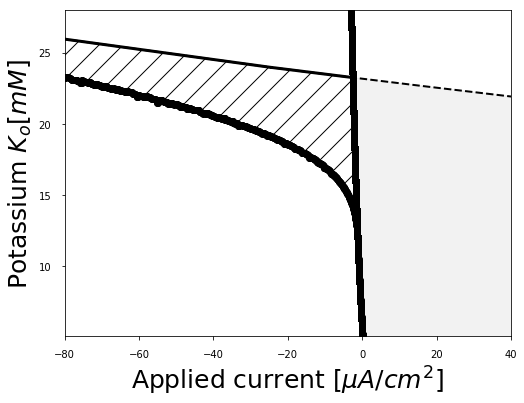

In [17]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('Potassium $K_o[mM]$',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()


# Second.. chapter 3: Sparsly connected networks

## Loading simulation s for different Ko's and extracting stats

In [18]:
# from scipy import signal
# from scipy.fftpack import fft
# import brian2
# from brian2.units import *
# from brian2 import *
# from brianutils import load_model
# resol=0.01#ms (min resolution of integration)
# from brian2 import units
# ### For plotting the histograms...
# import pandas as pd
# import seaborn as sns

# units = vars(units)


# ge_amp=0.035
# gi_amp=0.27
# koivv=[8,9,10,11.0,12.0,12.5,13.0, 13.5]
# si_v=[1.0]### sigma for white noise approximation..
# i_siiv=0
# koivv2=np.array(koivv)
# # iapi_v=np.array(mu_fr_vect)

# iapi_v=np.array([3.44756179, 3.09501356, 2.72745491, 2.34713872, 1.88336673,
#        1.64088176, 1.31921738, 0.9238477 ])

# # ### Will take as an example Ko 9.5 to see if the deltaU scales with T..
# # 1. load network data
# dir_SIMS=[]
# # conds
# time_stim=20000
# num_neurons=4000

# ##############################################################333
# ########### One Run..
# model_file='/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'


# m_prot_Ko=[]
# m_inDegree_K=[]
# a_a_v=[]
# a_b_v=[]
# a_var_v=[]
# a_mean_v=[]
# a_p_lfp_v=[]
# a_f_lfp_v=[]
# a_p_mean=[]
# a_p_var=[]
# a_ve=[]
# a_vi=[]
# a_vpop=[]
# a_JI=[]
# a_JE=[]
# a_iapi=[]

# K_v=[150.0,200.0,250.0,300.0,350.0,400.0,600.0]
# # K_v=[200.0,250.0,300.0,350.0,400.0]
# # v_num_neurons=[4000,6000,8000]

# ### Threshold for Ko=13.5 _> sn=-1.4846 , lc0=-1.9156 (Got from Auto continuation software)
# thetha_thres_v=[-0.5688,-1.2709,-1.9156]


# for iK in K_v:
#     v_prot_Ko=[]
#     v_inDegree_K=[]
#     v_a_v=[]
#     v_b_v=[]
#     v_var_v=[]
#     v_mean_v=[]
#     p_lfp_v=[]
#     f_lfp_v=[]
#     p_mean_v=[]
#     p_var_v=[]
#     v_ve=[]
#     v_vi=[]
#     v_vpop=[]
#     v_JI=[]
#     v_JE=[]
#     v_iapi=[]
#     ckoi=0
#     for K_o in koivv2:
#         iapi=iapi_v[ckoi]
#         bifparx={}

#         ge_amp=0.035*(200/iK)**0.5
#         gi_amp=0.27*(200/iK)**0.5
#         ############# Creating Fancy name to understand simulations later
#         num_runs=1
#         ii_num_realizations_4_smooth=1
#     #     num_neurons=4000
#         bifparx["I_app"]=[str(iapi)+"* uA/cm2"]#0.87 for low and -0.68 For high to achieve ~10Hz Fr
#         bifparx["K_o"]=["("+str(K_o)+"*mM)"]
#         ############# Creating Fancy name to understand simulations later
#         name='d_Network_N_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))
#         iapp='I_app'
#         ko='K_o'
#         dir_pars=bifparx
#         Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
#         if Koi_bifparx-int(Koi_bifparx)==0:
#             stringi=ko+'_'+str(int(Koi_bifparx))+'_'
#         else:
#             Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
#             stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
#         stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
#         stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
#         stringi=stringi+'pconnect_'+str(int(10.0))
#         stringi=stringi+'_wZoomIn2Volt'
#         stringi=stringi+'_multReal_num'+str(ii_num_realizations_4_smooth)+'wY_pres'
#         name=name+stringi+'imprPresMas'+'_inDegreeK_'+str(iK)
#         dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'
#         if os.path.isfile(dir_sims+name+'.pkl'):
#             try:
#                 print(name + ' Exists, or is being calculated.. :)')
#                 with open(dir_sims+name+'.pkl', "rb") as f:
#                     dir_i = pickle.load(f)


#                 for ii in range(len(dir_i)):
#                     print(dir_i[ii]['d_Protocol'])

#                     v_prot_Ko.append(K_o)
#                     v_inDegree_K.append(iK)
#                     v_a_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['a'])
#                     v_b_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['b'])
#                     v_var_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['var'])
#                     v_mean_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['mean'])
                    
#                     v_ve.append(np.mean(dir_i[ii]['Population_Rate']['Exc_Pop']))
#                     v_vi.append(np.mean(dir_i[ii]['Population_Rate']['Inh_Pop']))
#                     v_vpop.append(np.mean(dir_i[ii]['Population_Rate']['Freq_Pop']))
                    

#                     ## 6. Power spectrum population rates
#                     tt=dir_i[ii]['Population_Rate']['t']
#                     x=dir_i[ii]['Population_Rate']['Freq_Pop']
#                     fs=len(x)/((tt[-1]-tt[0])/1000)
#                     sliding_window=int(fs/1.0)#To get a 2.0Hz resolution
#                     overlap = 0.0
#                     n_overlap = int(sliding_window * overlap)
#                     f_lfp, p_lfp = signal.welch(x-np.mean(x), fs,'flattop',nperseg=sliding_window, noverlap=n_overlap,scaling='spectrum')

#                     p_lfp_v.append(p_lfp)
#                     f_lfp_v.append(f_lfp)
#                     p_mean_v.append(np.mean(x))
#                     p_var_v.append(np.var(x))
#                     v_JI.append(0.27*(200/iK)**0.5)
#                     v_JE.append(0.035*(200/iK)**0.5)
#                     v_iapi.append(iapi)


#             except:
#                 dir_sim_i={}
#                 v_prot_Ko.append([])
#                 v_inDegree_K.append([])
#                 v_a_v.append([])
#                 v_b_v.append([])
#                 v_var_v.append([])
#                 v_mean_v.append([])
#                 p_mean_v.append([])
#                 p_var_v.append([])
#                 p_lfp_v.append([])
#                 f_lfp_v.append([])
#                 v_JI.append([])
#                 v_JE.append([])
#                 v_ve.append([])
#                 v_vi.append([])
#                 v_vpop.append([])
#                 v_iapi.append([])
#                 pass
                
            
#         else:
#             ############# Running the network
#             # try:
#             dir_sim_i={}
#             v_prot_Ko.append([])
#             v_inDegree_K.append([])
#             v_a_v.append([])
#             v_b_v.append([])
#             v_var_v.append([])
#             v_mean_v.append([])
#             p_lfp_v.append([])
#             f_lfp_v.append([])
#             p_mean_v.append([])
#             p_var_v.append([])
#             v_JI.append([])
#             v_JE.append([])
#             v_ve.append([])
#             v_vi.append([])
#             v_vpop.append([])
#             v_iapi.append([])
#         #     save_obj(dir_sim_i, dir_sims+name)


#         ckoi+=1
    
#     m_prot_Ko.append(v_prot_Ko)
#     m_inDegree_K.append(v_inDegree_K)
#     a_a_v.append(v_a_v)
#     a_b_v.append(v_b_v)
#     a_var_v.append(v_var_v)
#     a_mean_v.append(v_mean_v)
#     a_p_lfp_v.append(p_lfp_v)
#     a_f_lfp_v.append(f_lfp_v)
#     a_p_mean.append(p_mean_v)
#     a_p_var.append(p_var_v)
#     a_JI.append(v_JI)
#     a_JE.append(v_JE)
#     a_ve.append(v_ve)
#     a_vi.append(v_vi)
#     a_vpop.append(v_vpop)
#     a_iapi.append(v_iapi)

In [19]:
# v_prot_Ko=[]
# vv_inDegree_K=[]
# vv_var_v=[]
# vv_mean_v=[]
# vv_theor_mu=[]
# vv_theor_sigma=[]
# vv_theor_c=[]
# vv_mean_fr=[]
# vv_mu_corrected=[]
# vv_ve=[]
# vv_vi=[]
# for ivkoi,vkoi in enumerate(m_prot_Ko):
#     for i_iikoi,iikoi in enumerate(vkoi):
#         if iikoi:
#             v_prot_Ko.append(iikoi)
#             vv_inDegree_K.append(m_inDegree_K[ivkoi][i_iikoi])
#             vv_var_v.append(a_var_v[ivkoi][i_iikoi])
#             vv_mean_v.append(a_mean_v[ivkoi][i_iikoi])
#             muE=5.0/1000*a_ve[ivkoi][i_iikoi]*a_JE[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi]
#             muI=10.0/1000*a_vi[ivkoi][i_iikoi]*a_JI[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi]
#             vv_theor_mu.append(muE-muI+a_iapi[ivkoi][i_iikoi])
#             sigE=2*a_JE[ivkoi][i_iikoi]*np.sqrt(5.0/1000*a_ve[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi])## the 2 comes from the conductance..
#             sigI=2*a_JI[ivkoi][i_iikoi]*np.sqrt(10.0/1000*a_vi[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi])## the 2 comes from the conductance..
#             vv_theor_sigma.append(sigE+sigI)
#             cc=np.sqrt(200)*(np.sqrt(200)-np.sqrt(m_inDegree_K[ivkoi][i_iikoi]))*(5.0/1000*a_ve[ivkoi][i_iikoi]*a_JE[ivkoi][i_iikoi]+10.0/1000*a_vi[ivkoi][i_iikoi]*a_JI[ivkoi][i_iikoi])/a_iapi[ivkoi][i_iikoi]+1
#             vv_theor_c.append(cc)
#             vv_mu_corrected.append(muE-muI+a_iapi[ivkoi][i_iikoi]*np.sqrt(m_inDegree_K[ivkoi][i_iikoi]))
#             vv_ve.append(a_ve[ivkoi][i_iikoi])
#             vv_vi.append(a_vi[ivkoi][i_iikoi])

In [20]:
# data0=[v_prot_Ko,vv_inDegree_K,vv_var_v,vv_mean_v,vv_theor_mu,vv_theor_sigma,vv_mu_corrected,vv_ve]
# df_stats = pd.DataFrame(columns=['K_o','in-degree','sigma','mu','theor_mu','theor_sigma','corrected_mu','v_E'], data=np.array(data0).T)
# df_stats['in-degree'] = df_stats['in-degree'].astype(float)
# df_stats['in-degree'].dropna().unique()
# df_stats['sigma'] = df_stats['sigma'].astype(float)
# df_stats['sigma'].dropna().unique()
# df_stats['mu'] = df_stats['mu'].astype(float)
# df_stats['mu'].dropna().unique()



In [21]:
# # f, ax = plt.subplots(figsize=(7, 7))

# ax=sns.lmplot(x ='in-degree', y ='sigma', hue ='K_o',
#            fit_reg = False, data = df_stats)

# ax.set(yscale="log")
# # ax.ylabel('log Sigma')

In [22]:
# model = np.polyfit(df_stats['in-degree'][df_stats['K_o']==13.5], np.log(df_stats['sigma'][df_stats['K_o']==13.5]), 1)
# model

In [23]:

# ko=8.0
# model = np.polyfit(df_stats['in-degree'][df_stats['K_o']==ko], np.log(df_stats['sigma'][df_stats['K_o']==ko]), 1)
# model

In [24]:
# sns.lmplot(x ='in-degree', y ='sigma', hue ='K_o',
#            fit_reg = False, data = df_stats) 

# plt.show

In [25]:
# sns.lmplot(x ='in-degree', y ='theor_sigma', hue ='K_o',
#            fit_reg = False, data = df_stats) 

# plt.show

In [26]:
# sns.lmplot(x ='in-degree', y ='v_E', hue ='K_o',
#            fit_reg = False, data = df_stats) 

# plt.show

In [27]:
# sns.lmplot(x ='in-degree', y ='mu', hue ='K_o',
#            fit_reg = False, data = df_stats) 

# plt.show

In [28]:
# sns.lmplot(x ='in-degree', y ='theor_mu', hue ='K_o',
#            fit_reg = False, data = df_stats) 

# plt.show

In [29]:
from scipy import signal
from scipy.fftpack import fft
import brian2
from brian2.units import *
from brian2 import *
from brianutils import load_model
resol=0.01#ms (min resolution of integration)
from brian2 import units
### For plotting the histograms...
import pandas as pd
import seaborn as sns

units = vars(units)


ge_amp=0.035
gi_amp=0.27
koivv=[8,9,10,11.0,12.0,12.5,13.0, 13.5]
si_v=[1.0]### sigma for white noise approximation..
i_siiv=0
koivv2=np.array(koivv)
# iapi_v=np.array(mu_fr_vect)

iapi_v=np.array([3.44756179, 3.09501356, 2.72745491, 2.34713872, 1.88336673,
       1.64088176, 1.31921738, 0.9238477 ])

# ### Will take as an example Ko 9.5 to see if the deltaU scales with T..
# 1. load network data
dir_SIMS=[]
# conds
time_stim=20000
num_neurons=4000

##############################################################333
########### One Run..
model_file='/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'


m_prot_Ko=[]
m_inDegree_K=[]
a_a_v=[]
a_b_v=[]
a_var_v=[]
a_mean_v=[]
a_p_lfp_v=[]
a_f_lfp_v=[]
a_p_mean=[]
a_p_var=[]
a_ve=[]
a_vi=[]
a_vpop=[]
a_JI=[]
a_JE=[]
a_iapi=[]

K_v=[150.0,200.0,250.0,300.0,350.0,400.0,600.0]
# K_v=[200.0,250.0,300.0,350.0,400.0]
# v_num_neurons=[4000,6000,8000]

### Threshold for Ko=13.5 _> sn=-1.4846 , lc0=-1.9156 (Got from Auto continuation software)
thetha_thres_v=[-0.5688,-1.2709,-1.9156]


for iK in K_v:
    v_prot_Ko=[]
    v_inDegree_K=[]
    v_a_v=[]
    v_b_v=[]
    v_var_v=[]
    v_mean_v=[]
    p_lfp_v=[]
    f_lfp_v=[]
    p_mean_v=[]
    p_var_v=[]
    v_ve=[]
    v_vi=[]
    v_vpop=[]
    v_JI=[]
    v_JE=[]
    v_iapi=[]
    ckoi=0
    for K_o in koivv2:
        iapi=iapi_v[ckoi]*(iK/200)**0.5
        bifparx={}

        ge_amp=0.035*(200/iK)**0.5
        gi_amp=0.27*(200/iK)**0.5
        ############# Creating Fancy name to understand simulations later
        num_runs=1
        ii_num_realizations_4_smooth=1
    #     num_neurons=4000
        bifparx["I_app"]=[str(iapi)+"* uA/cm2"]#0.87 for low and -0.68 For high to achieve ~10Hz Fr
        bifparx["K_o"]=["("+str(K_o)+"*mM)"]
        ############# Creating Fancy name to understand simulations later
        name='d_Network_N_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))
        iapp='I_app'
        ko='K_o'
        dir_pars=bifparx
        Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
        if Koi_bifparx-int(Koi_bifparx)==0:
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'
        else:
            Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
        stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
        stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
        stringi=stringi+'pconnect_'+str(int(10.0))
        stringi=stringi+'_wZoomIn2Volt'
        stringi=stringi+'_multReal_num'+str(ii_num_realizations_4_smooth)+'wY_pres'
        name=name+stringi+'imprPresMas'+'_inDegreeK_'+str(iK)+'_scaled'
        dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'
        if os.path.isfile(dir_sims+name+'.pkl'):
            try:
                print(name + ' Exists, or is being calculated.. :)')
                with open(dir_sims+name+'.pkl', "rb") as f:
                    dir_i = pickle.load(f)


                for ii in range(len(dir_i)):
                    print(dir_i[ii]['d_Protocol'])

                    v_prot_Ko.append(K_o)
                    v_inDegree_K.append(iK)
                    v_a_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['a'])
                    v_b_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['b'])
                    v_var_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['var'])
                    v_mean_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['mean'])
                    
                    v_ve.append(np.mean(dir_i[ii]['Population_Rate']['Exc_Pop']))
                    v_vi.append(np.mean(dir_i[ii]['Population_Rate']['Inh_Pop']))
                    v_vpop.append(np.mean(dir_i[ii]['Population_Rate']['Freq_Pop']))
                    

                    ## 6. Power spectrum population rates
                    tt=dir_i[ii]['Population_Rate']['t']
                    x=dir_i[ii]['Population_Rate']['Freq_Pop']
                    fs=len(x)/((tt[-1]-tt[0])/1000)
                    sliding_window=int(fs/1.0)#To get a 2.0Hz resolution
                    overlap = 0.0
                    n_overlap = int(sliding_window * overlap)
                    f_lfp, p_lfp = signal.welch(x-np.mean(x), fs,'flattop',nperseg=sliding_window, noverlap=n_overlap,scaling='spectrum')

                    p_lfp_v.append(p_lfp)
                    f_lfp_v.append(f_lfp)
                    p_mean_v.append(np.mean(x))
                    p_var_v.append(np.var(x))
                    v_JI.append(0.27*(200/iK)**0.5)
                    v_JE.append(0.035*(200/iK)**0.5)
                    v_iapi.append(iapi)


            except:
                dir_sim_i={}
                v_prot_Ko.append([])
                v_inDegree_K.append([])
                v_a_v.append([])
                v_b_v.append([])
                v_var_v.append([])
                v_mean_v.append([])
                p_mean_v.append([])
                p_var_v.append([])
                p_lfp_v.append([])
                f_lfp_v.append([])
                v_JI.append([])
                v_JE.append([])
                v_ve.append([])
                v_vi.append([])
                v_vpop.append([])
                v_iapi.append([])
                pass
                
            
        else:
            ############# Running the network
            # try:
            dir_sim_i={}
            v_prot_Ko.append([])
            v_inDegree_K.append([])
            v_a_v.append([])
            v_b_v.append([])
            v_var_v.append([])
            v_mean_v.append([])
            p_lfp_v.append([])
            f_lfp_v.append([])
            p_mean_v.append([])
            p_var_v.append([])
            v_JI.append([])
            v_JE.append([])
            v_ve.append([])
            v_vi.append([])
            v_vpop.append([])
            v_iapi.append([])
        #     save_obj(dir_sim_i, dir_sims+name)


        ckoi+=1
    
    m_prot_Ko.append(v_prot_Ko)
    m_inDegree_K.append(v_inDegree_K)
    a_a_v.append(v_a_v)
    a_b_v.append(v_b_v)
    a_var_v.append(v_var_v)
    a_mean_v.append(v_mean_v)
    a_p_lfp_v.append(p_lfp_v)
    a_f_lfp_v.append(f_lfp_v)
    a_p_mean.append(p_mean_v)
    a_p_var.append(p_var_v)
    a_JI.append(v_JI)
    a_JE.append(v_JE)
    a_ve.append(v_ve)
    a_vi.append(v_vi)
    a_vpop.append(v_vpop)
    a_iapi.append(v_iapi)

d_Network_N_4000_num_runs_1_lengthSim_20000K_o_8_I_app_29ge_4_gi_31pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_150.0_scaled Exists, or is being calculated.. :)
{'bifparx': {'I_app': ['2.985676091256552* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
d_Network_N_4000_num_runs_1_lengthSim_20000K_o_11_I_app_20ge_4_gi_31pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_150.0_scaled Exists, or is being calculated.. :)
{'bifparx': {'I_app': ['2.03268175772609* uA/cm2'], 'K_o': ['(11.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
d_Network_N_4000_num_runs_1_lengthSim_20000K_o_13_I_app_11ge_4_gi_31pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_150.0_scaled Exists, or is being calculated.. :)
{'bifparx': {'I

In [30]:
v_prot_Ko=[]
vv_inDegree_K=[]
vv_var_v=[]
vv_mean_v=[]
vv_theor_mu=[]
vv_theor_sigma=[]
vv_theor_c=[]
vv_mean_fr=[]
vv_mu_corrected=[]
vv_ve=[]
vv_vi=[]
for ivkoi,vkoi in enumerate(m_prot_Ko):
    for i_iikoi,iikoi in enumerate(vkoi):
        if iikoi:
            v_prot_Ko.append(iikoi)
            vv_inDegree_K.append(m_inDegree_K[ivkoi][i_iikoi])
            vv_var_v.append(a_var_v[ivkoi][i_iikoi])
            vv_mean_v.append(a_mean_v[ivkoi][i_iikoi])
            muE=5.0/1000*a_ve[ivkoi][i_iikoi]*a_JE[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi]
            muI=10.0/1000*a_vi[ivkoi][i_iikoi]*a_JI[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi]
            vv_theor_mu.append(muE-muI+a_iapi[ivkoi][i_iikoi])
            sigE=2*a_JE[ivkoi][i_iikoi]*np.sqrt(5.0/1000*a_ve[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi])## the 2 comes from the conductance..
            sigI=2*a_JI[ivkoi][i_iikoi]*np.sqrt(10.0/1000*a_vi[ivkoi][i_iikoi]*m_inDegree_K[ivkoi][i_iikoi])## the 2 comes from the conductance..
            vv_theor_sigma.append(sigE+sigI)
            cc=np.sqrt(200)*(np.sqrt(200)-np.sqrt(m_inDegree_K[ivkoi][i_iikoi]))*(5.0/1000*a_ve[ivkoi][i_iikoi]*a_JE[ivkoi][i_iikoi]+10.0/1000*a_vi[ivkoi][i_iikoi]*a_JI[ivkoi][i_iikoi])/a_iapi[ivkoi][i_iikoi]+1
            vv_theor_c.append(cc)
            vv_mu_corrected.append(muE-muI+a_iapi[ivkoi][i_iikoi]*np.sqrt(m_inDegree_K[ivkoi][i_iikoi]))
            vv_ve.append(a_ve[ivkoi][i_iikoi])
            vv_vi.append(a_vi[ivkoi][i_iikoi])
            



In [31]:
data0=[v_prot_Ko,vv_inDegree_K,vv_var_v,np.sqrt(vv_var_v),vv_mean_v,vv_theor_mu,vv_theor_sigma,vv_mu_corrected,vv_ve]
df_stats = pd.DataFrame(columns=['K_o','in-degree','sigma2','sigma','mu','theor_mu','theor_sigma','corrected_mu','v_E'], data=np.array(data0).T)
df_stats['in-degree'] = df_stats['in-degree'].astype(float)
df_stats['in-degree'].dropna().unique()
df_stats['sigma'] = df_stats['sigma'].astype(float)
df_stats['sigma'].dropna().unique()
df_stats['mu'] = df_stats['mu'].astype(float)
df_stats['mu'].dropna().unique()



array([-1.7200253 , -2.73239608, -3.96710605, -4.31672303, -1.79010485,
       -2.57102873, -3.57285018, -3.85893589, -1.70333788, -2.57531067,
       -3.53009686, -3.7648025 , -1.48534981, -2.50720847, -3.31996712,
       -3.61101381])

<function matplotlib.pyplot.show(*args, **kw)>

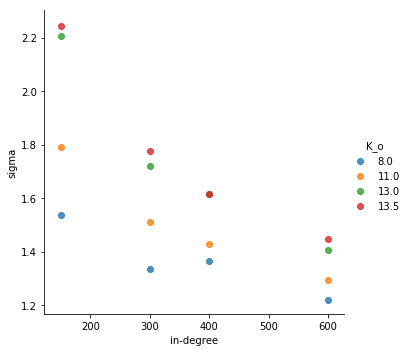

In [32]:
sns.lmplot(x ='in-degree', y ='sigma', hue ='K_o',
           fit_reg = False, data = df_stats) 

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

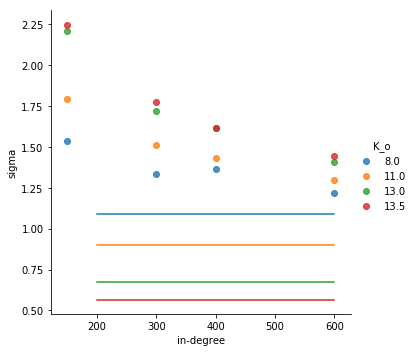

In [33]:
sns.lmplot(x ='in-degree', y ='sigma', hue ='K_o',
           fit_reg = False, data = df_stats) 

plt.show

ge_amp_i=0.035
gi_amp_i=0.27
tau_e=5/1000.0
tau_i=10/1000.0
for koii in np.unique(df_stats['K_o']):
    idxkoii=[ii for ii,koi in enumerate(koivv2) if koii==koi]
    I_apii_ko=iapi_v[idxkoii[0]]
    ve_theori=-I_apii_ko/(np.sqrt(200*200)*(tau_e*ge_amp_i-tau_i*gi_amp_i))
    sigi_theor=ge_amp_i*np.sqrt(ve_theori*tau_e*200)+gi_amp_i*np.sqrt(ve_theori*tau_i*200)
    plt.plot(np.linspace(200,600,5),np.ones(5)*sigi_theor)

plt.show

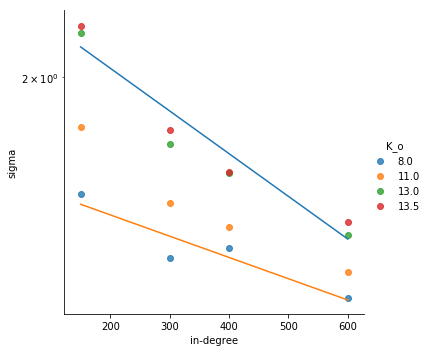

In [34]:

ax=sns.lmplot(x ='in-degree', y ='sigma', hue ='K_o',
           fit_reg = False, data = df_stats)
ax.set(yscale="log")

#### 13.5
koii=13.5
model = np.polyfit(df_stats['in-degree'][df_stats['K_o']==koii], np.log(df_stats['sigma'][df_stats['K_o']==koii]), 1)
poly = np.poly1d(model)
yfit = lambda x: np.exp(poly(x))

plt.plot(np.array(df_stats['in-degree'][df_stats['K_o']==koii]),yfit(np.array(df_stats['in-degree'][df_stats['K_o']==koii])))


#### 8.0
koii=8.0
model = np.polyfit(df_stats['in-degree'][df_stats['K_o']==koii], np.log(df_stats['sigma'][df_stats['K_o']==koii]), 1)
poly = np.poly1d(model)
yfit = lambda x: np.exp(poly(x))

plt.plot(np.array(df_stats['in-degree'][df_stats['K_o']==koii]),yfit(np.array(df_stats['in-degree'][df_stats['K_o']==koii])))


In [35]:
model = np.polyfit(df_stats['in-degree'][df_stats['K_o']==13.5], np.log(df_stats['sigma'][df_stats['K_o']==13.5]), 1)
model
1/model[0]

-1047.9581854617431

In [36]:
model = np.polyfit(df_stats['in-degree'][df_stats['K_o']==8.0], np.log(df_stats['sigma'][df_stats['K_o']==8.0]), 1)
model
1/model[0]

-2103.6879169690537

In [37]:
model = np.polyfit(df_stats['in-degree'][df_stats['K_o']==13.5], np.log(df_stats['sigma'][df_stats['K_o']==13.5]), 1)
model

array([-0.00095424,  0.9031854 ])

<function matplotlib.pyplot.show(*args, **kw)>

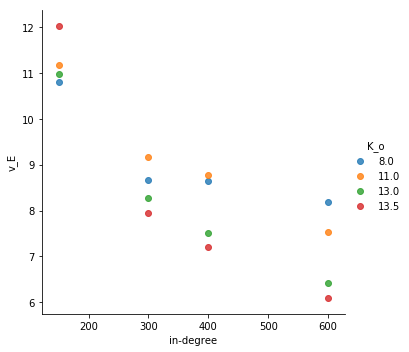

In [38]:
sns.lmplot(x ='in-degree', y ='v_E', hue ='K_o',
           fit_reg = False, data = df_stats) 

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

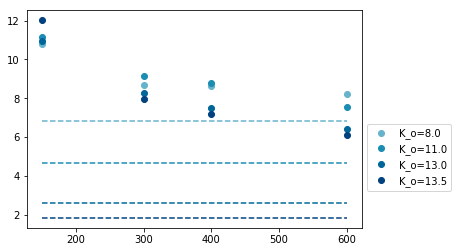

In [39]:
# ax=sns.lmplot(x ='in-degree', y ='v_E', hue ='K_o',
#            fit_reg = False, data = df_stats) 
cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)


ge_amp_i=0.035
gi_amp_i=0.27
tau_e=5/1000.0
tau_i=10/1000.0
for koii in np.unique(df_stats['K_o']):
    colorii=next(colors)
    plt.plot(df_stats['in-degree'][df_stats['K_o']==koii],df_stats['v_E'][df_stats['K_o']==koii],'o',color=colorii,label='K_o='+str(koii))
    idxkoii=[ii for ii,koi in enumerate(koivv2) if koii==koi]
    I_apii_ko=iapi_v[idxkoii[0]]
    ve_theori=-I_apii_ko/(200*(tau_e*ge_amp_i-tau_i*gi_amp_i))
    plt.plot(np.linspace(150,600,5),np.ones(5)*ve_theori,'--',color=colorii)

plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

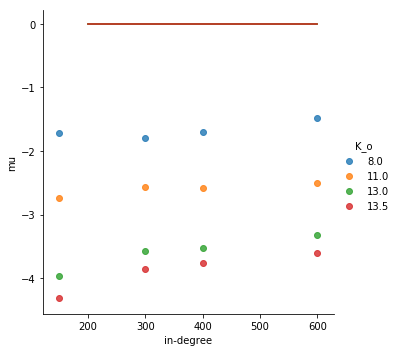

In [40]:
sns.lmplot(x ='in-degree', y ='mu', hue ='K_o',
           fit_reg = False, data = df_stats) 

ge_amp_i=0.035
gi_amp_i=0.27
tau_e=5/1000.0
tau_i=10/1000.0
for koii in np.unique(df_stats['K_o']):
    idxkoii=[ii for ii,koi in enumerate(koivv2) if koii==koi]
    I_apii_ko=iapi_v[idxkoii[0]]
    ve_theori=-I_apii_ko/(np.sqrt(200*200)*(tau_e*ge_amp_i-tau_i*gi_amp_i))
    mue_theori=ve_theori*tau_e*ge_amp_i*np.sqrt(200)-ve_theori*tau_i*gi_amp_i*np.sqrt(200)+I_apii_ko/np.sqrt(200)
    plt.plot(np.linspace(200,600,5),np.ones(5)*mue_theori)

plt.show


plt.show

In [41]:
I_apii_ko

0.9238477

In [42]:
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])
fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
 [py.warnings]


Ko=13.0
2.6123116435643556
1.31921738


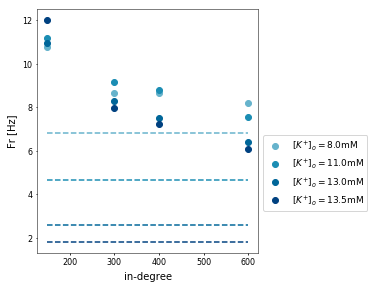

<Figure size 410.4x360 with 0 Axes>

In [43]:
# ax=sns.lmplot(x ='in-degree', y ='v_E', hue ='K_o',
#            fit_reg = False, data = df_stats) 

f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax=plt.subplot2grid((10,10), (0, 0), colspan=7,rowspan=9)


cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)


ge_amp_i=0.035
gi_amp_i=0.27
tau_e=5/1000.0
tau_i=10/1000.0
for koii in np.unique(df_stats['K_o']):
    colorii=next(colors)
    ax.plot(df_stats['in-degree'][df_stats['K_o']==koii],df_stats['v_E'][df_stats['K_o']==koii],'o',color=colorii,label='$[K^{+}]_o='+str(koii)+'$mM')
    idxkoii=[ii for ii,koi in enumerate(koivv2) if koii==koi]
    I_apii_ko=iapi_v[idxkoii[0]]
    ve_theori=-I_apii_ko/(200*(tau_e*ge_amp_i-tau_i*gi_amp_i))
    ax.plot(np.linspace(150,600,5),np.ones(5)*ve_theori,'--',color=colorii)
    if koii==13:
        print('Ko='+str(koii))
        print(str(ve_theori))
        print(I_apii_ko)

ax.set_ylabel('Fr [Hz]',labelpad=5)
ax.set_xlabel('in-degree',labelpad=5)
ax.legend(loc='best', bbox_to_anchor=(1, 0.5))
    
dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
name_file='PopulationActivity_vs_K_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
iapp='I_app'
ko='K_o'
stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=name_file+stringi+'N_'+str(num_neurons)+'_multKs'
fig_file_title='fig_'+name
md_dir={
        'Title':'PopulationActivity PowerSpectrum',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]))),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

saving_pdf_figure(f11,'./Figs/'+fig_file_title,md_dir)

f11.show()

8.0
150.0
3.0000015000007494
13.0
150.0
4.0000020000009995
8.0
300.0
5.00000250000125
13.0
300.0
4.0000020000009995
8.0
400.0
3.0000015000007494
13.0
400.0
3.0000015000007494
8.0
600.0
3.0000015000007494
13.0
600.0
3.0000015000007494


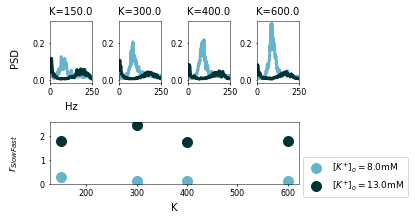

<Figure size 410.4x360 with 0 Axes>

In [44]:
lxaxs=250

v_num_neurons_ii=K_v
f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.6))
ax=[]

i_N_st_tot=0
for i_N in range(len(v_num_neurons_ii)):
    if len(a_f_lfp_v[i_N][0])>0:
        i_N_st_tot+=1



i_N_st=0
for i_N in range(len(v_num_neurons_ii)):
    if len(a_f_lfp_v[i_N][0])>0:
        if i_N_st==0:
            ax.append(plt.subplot2grid((5,3*i_N_st_tot+2), (0, i_N_st*3), colspan=2,rowspan=2))
        else:
            ax.append(plt.subplot2grid((5,3*i_N_st_tot+2), (0, i_N_st*3),sharey=ax[0], colspan=2,rowspan=2))
    
        i_N_st+=1
        
ax.append(plt.subplot2grid((5,3*i_N_st_tot+2), (3, 0), colspan=3*i_N_st_tot-1,rowspan=2))



a_v_ratio=[]
i_N_st=0
v_num_neurons_ii_st=[]
for i_N in range(len(v_num_neurons_ii)):
    Spectrogram_Fr_v=a_f_lfp_v[i_N]
    Spectrogram_v=a_p_lfp_v[i_N]
    size_legend_font=20
    cmap=plt.get_cmap('ocean')
    colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
    colorii=next(colors)
    colorii=next(colors)
    v_ratio=[]
    if len(a_f_lfp_v[i_N][0])>0:
        for koii in range(len(koivv2)):
            colorii=next(colors)
            if koii in [0,6]:
                ax[i_N_st].plot(Spectrogram_Fr_v[koii], Spectrogram_v[koii],label='$[K^{+}]_o='+str(koivv2[koii])+'$mM',color=colorii,linewidth=3)
                ax[i_N_st].set_xlim([-3,lxaxs])
                slw_peak=max(Spectrogram_v[koii][Spectrogram_Fr_v[koii]<6])
                print(str(koivv2[koii]))
                print(v_num_neurons_ii[i_N])
                print(Spectrogram_Fr_v[koii][argmax(Spectrogram_v[koii][Spectrogram_Fr_v[koii]<6])])
                fst_peak=max(Spectrogram_v[koii][(Spectrogram_Fr_v[koii]>50)*(Spectrogram_Fr_v[koii]<lxaxs)])
                v_ratio.append(slw_peak/fst_peak)

        a_v_ratio.append(v_ratio)
        v_num_neurons_ii_st.append(v_num_neurons_ii[i_N])
        ax[i_N_st].set_xlim([-3,lxaxs])
        ax[i_N_st].set_title('K='+str(v_num_neurons_ii[i_N]))
        i_N_st+=1
    
# ax[0].set_ylabel('PSD',fontsize=size_axis_font,labelpad=10)
# ax[0].set_xlabel('Hz',fontsize=size_axis_font,labelpad=10)
ax[0].set_ylabel('PSD',labelpad=5)
ax[0].set_xlabel('Hz',labelpad=5)


# ax[len(v_num_neurons)-1].set_xlabel('[Hz]',fontsize=size_axis_font,labelpad=10)


cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)
cc=0
for koii in range(len(koivv2)):
    colorii=next(colors)
    if koii in [0,6]:
        ax[-1].plot(v_num_neurons_ii_st, np.array(a_v_ratio).T[cc],'o',markersize=10, label='$[K^{+}]_o='+str(koivv2[koii])+'$mM',color=colorii)
        cc+=1

# ax[len(v_num_neurons_ii)].set_xlabel('N',fontsize=size_axis_font,labelpad=10)
# ax[len(v_num_neurons_ii)].set_ylabel(r'$r_{SlowFast}$',fontsize=size_axis_font,labelpad=10)
ax[-1].set_xlabel('K',labelpad=5)
ax[-1].set_ylabel(r'$r_{SlowFast}$',labelpad=5)


# ax[len(v_num_neurons_ii)-1].legend(title='Extracellular potassium',loc='best', bbox_to_anchor=(1, 1),prop={'size': size_legend_font})
# ax[len(v_num_neurons_ii)-1].legend(loc='best', bbox_to_anchor=(1, 0.5),prop={'size': size_legend_font})
ax[-1].legend(loc='best', bbox_to_anchor=(1, 0.5))



# locatory1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
ax[-1].xaxis.set_major_locator(locatorx1)

############################################
### Aligning y labels
############################################
labely = -0.12  # axes coords
boxP =ax[i_N_st].get_position()
box0p =ax[0].get_position()
ax[i_N_st].yaxis.set_label_coords(labely, 0.5)
ax[0].yaxis.set_label_coords(boxP.width/box0p.width*labely, 0.4)



dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
name_file='PopulationActivity_PowerSpectrum__num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
iapp='I_app'
ko='K_o'
stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=name_file+stringi+'N_'+str(num_neurons)+'_multKs'
fig_file_title='fig_'+name
md_dir={
        'Title':'PopulationActivity PowerSpectrum',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]))),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

saving_pdf_figure(f11,'./Figs/'+fig_file_title,md_dir)

f11.show()

## theoretical Iapp for $v_e(K \to \inf)=5Hz$

In [45]:
## theoretical Iapp for v_e(K \to \inf)=5Hz
-5*(200*(tau_e*ge_amp_i-tau_i*gi_amp_i))

2.5250000000000004

In [46]:
koivv2

array([ 8. ,  9. , 10. , 11. , 12. , 12.5, 13. , 13.5])

In [106]:
from scipy import signal
from scipy.fftpack import fft
import brian2
from brian2.units import *
from brian2 import *
from brianutils import load_model
resol=0.01#ms (min resolution of integration)
from brian2 import units
### For plotting the histograms...
import pandas as pd
import seaborn as sns

units = vars(units)


ge_amp=0.035
gi_amp=0.27
koivv=[8,9,10,11.0,12.0,12.5,13.0, 13.5]
si_v=[1.0]### sigma for white noise approximation..
i_siiv=0
koivv2=np.array(koivv)
# iapi_v=np.array(mu_fr_vect)

iapi_v=np.array([3.44756179, 3.09501356, 2.72745491, 2.34713872, 1.88336673,
       1.64088176, 1.31921738, 0.9238477 ])

# ### Will take as an example Ko 9.5 to see if the deltaU scales with T..
# 1. load network data
dir_SIMS=[]
# conds
time_stim=20000
num_neurons=4000

##############################################################333
########### One Run..
model_file='/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'


m_prot_Ko_5Hz=[]
m_inDegree_K_5Hz=[]
a_a_v_5Hz=[]
a_b_v_5Hz=[]
a_var_v_5Hz=[]
a_mean_v_5Hz=[]
a_p_lfp_v_5Hz=[]
a_f_lfp_v_5Hz=[]
a_p_mean_5Hz=[]
a_p_var_5Hz=[]
a_ve_5Hz=[]
a_vi_5Hz=[]
a_vpop_5Hz=[]
a_JI_5Hz=[]
a_JE_5Hz=[]
a_iapi_5Hz=[]

K_v=[150.0,200.0,250.0,300.0,350.0,400.0,500.0,600.0]
# K_v=[200.0,250.0,300.0,350.0,400.0]
# v_num_neurons=[4000,6000,8000]

### Threshold for Ko=13.5 _> sn=-1.4846 , lc0=-1.9156 (Got from Auto continuation software)
thetha_thres_v=[-0.5688,-1.2709,-1.9156]

# K_v=[150.0,200.0,300.0,400.0,500.0,600.0]
# K_v=[200.0,500.0,600.0]

for iK in K_v:
    v_prot_Ko=[]
    v_inDegree_K=[]
    v_a_v=[]
    v_b_v=[]
    v_var_v=[]
    v_mean_v=[]
    p_lfp_v=[]
    f_lfp_v=[]
    p_mean_v=[]
    p_var_v=[]
    v_ve=[]
    v_vi=[]
    v_vpop=[]
    v_JI=[]
    v_JE=[]
    v_iapi=[]
    ckoi=0
    for K_o in koivv2:
#         iapi=iapi_v[ckoi]*(iK/200)**0.5
        iapi=2.5 ### for MFT(K->infty)=5Hz 
        bifparx={}

        ge_amp=0.035*(200/iK)**0.5
        gi_amp=0.27*(200/iK)**0.5
        ############# Creating Fancy name to understand simulations later
        num_runs=1
        ii_num_realizations_4_smooth=1
    #     num_neurons=4000
        bifparx["I_app"]=[str(iapi)+"* uA/cm2"]#0.87 for low and -0.68 For high to achieve ~10Hz Fr
        bifparx["K_o"]=["("+str(K_o)+"*mM)"]
        ############# Creating Fancy name to understand simulations later
        name='d_Network_N_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))
        iapp='I_app'
        ko='K_o'
        dir_pars=bifparx
        Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
        if Koi_bifparx-int(Koi_bifparx)==0:
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'
        else:
            Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
        stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
        stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
        stringi=stringi+'pconnect_'+str(int(10.0))
        stringi=stringi+'_wZoomIn2Volt'
        stringi=stringi+'_multReal_num'+str(ii_num_realizations_4_smooth)+'wY_pres'
        name0=name+stringi+'imprPresMas'+'_inDegreeK_'+str(int(iK))+'_scaled_MFT_5Hz'
        name1=name+stringi+'imprPresMas'+'_inDegreeK_'+str(iK)+'_scaled_MFT_5Hz'
        dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'
        name=name0
        if os.path.isfile(dir_sims+name0+'.pkl'):
            name=name0
        if os.path.isfile(dir_sims+name1+'.pkl'):
            name=name1
        if os.path.isfile(dir_sims+name+'.pkl'):
            try:
                print(name + ' Exists, or is being calculated.. :)')
                with open(dir_sims+name+'.pkl', "rb") as f:
                    dir_i = pickle.load(f)


                for ii in range(len(dir_i)):
                    print(dir_i[ii]['d_Protocol'])

                    v_prot_Ko.append(K_o)
                    v_inDegree_K.append(iK)
                    v_a_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['a'])
                    v_b_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['b'])
                    v_var_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['var'])
                    v_mean_v.append(dir_i[ii]['Spiking_zoom']['input_distribution_2all']['mean'])
                    
                    v_ve.append(np.mean(dir_i[ii]['Population_Rate']['Exc_Pop']))
                    v_vi.append(np.mean(dir_i[ii]['Population_Rate']['Inh_Pop']))
                    v_vpop.append(np.mean(dir_i[ii]['Population_Rate']['Freq_Pop']))
                    

                    ## 6. Power spectrum population rates
                    tt=dir_i[ii]['Population_Rate']['t']
                    x=dir_i[ii]['Population_Rate']['Freq_Pop']
                    fs=len(x)/((tt[-1]-tt[0])/1000)
                    sliding_window=int(fs/1.0)#To get a 2.0Hz resolution
                    overlap = 0.0
                    n_overlap = int(sliding_window * overlap)
                    f_lfp, p_lfp = signal.welch(x-np.mean(x), fs,'flattop',nperseg=sliding_window, noverlap=n_overlap,scaling='spectrum')

                    p_lfp_v.append(p_lfp)
                    f_lfp_v.append(f_lfp)
                    p_mean_v.append(np.mean(x))
                    p_var_v.append(np.var(x))
                    v_JI.append(0.27*(200/iK)**0.5)
                    v_JE.append(0.035*(200/iK)**0.5)
                    v_iapi.append(iapi)


            except:
                dir_sim_i={}
                v_prot_Ko.append([])
                v_inDegree_K.append([])
                v_a_v.append([])
                v_b_v.append([])
                v_var_v.append([])
                v_mean_v.append([])
                p_mean_v.append([])
                p_var_v.append([])
                p_lfp_v.append([])
                f_lfp_v.append([])
                v_JI.append([])
                v_JE.append([])
                v_ve.append([])
                v_vi.append([])
                v_vpop.append([])
                v_iapi.append([])
                pass
                
            
        else:
            ############# Running the network
            # try:
            print( ' !!! doesnt exist !!!  '+name)
            dir_sim_i={}
            v_prot_Ko.append([])
            v_inDegree_K.append([])
            v_a_v.append([])
            v_b_v.append([])
            v_var_v.append([])
            v_mean_v.append([])
            p_lfp_v.append([])
            f_lfp_v.append([])
            p_mean_v.append([])
            p_var_v.append([])
            v_JI.append([])
            v_JE.append([])
            v_ve.append([])
            v_vi.append([])
            v_vpop.append([])
            v_iapi.append([])
        #     save_obj(dir_sim_i, dir_sims+name)


        ckoi+=1
    
    m_prot_Ko_5Hz.append(v_prot_Ko)
    m_inDegree_K_5Hz.append(v_inDegree_K)
    a_a_v_5Hz.append(v_a_v)
    a_b_v_5Hz.append(v_b_v)
    a_var_v_5Hz.append(v_var_v)
    a_mean_v_5Hz.append(v_mean_v)
    a_p_lfp_v_5Hz.append(p_lfp_v)
    a_f_lfp_v_5Hz.append(f_lfp_v)
    a_p_mean_5Hz.append(p_mean_v)
    a_p_var_5Hz.append(p_var_v)
    a_JI_5Hz.append(v_JI)
    a_JE_5Hz.append(v_JE)
    a_ve_5Hz.append(v_ve)
    a_vi_5Hz.append(v_vi)
    a_vpop_5Hz.append(v_vpop)
    a_iapi_5Hz.append(v_iapi)

d_Network_N_4000_num_runs_1_lengthSim_20000K_o_8_I_app_25ge_4_gi_31pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_150.0_scaled_MFT_5Hz Exists, or is being calculated.. :)
{'bifparx': {'I_app': ['2.5* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_9_I_app_25ge_4_gi_31pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_150_scaled_MFT_5Hz
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_10_I_app_25ge_4_gi_31pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_150_scaled_MFT_5Hz
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_11_I_app_25ge_4_gi_31pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_150_scaled_MFT_5Hz
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_12_I_a

{'bifparx': {'I_app': ['2.5* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_9_I_app_25ge_2_gi_19pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_400_scaled_MFT_5Hz
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_10_I_app_25ge_2_gi_19pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_400_scaled_MFT_5Hz
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_11_I_app_25ge_2_gi_19pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_400_scaled_MFT_5Hz
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_12_I_app_25ge_2_gi_19pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_400_scaled_MFT_5Hz
 !!! doesnt exist !!!  d_Network_N_4000_num_runs_1_lengthSim_20000K_o_12_50_I_app_25ge_2_g

In [107]:
v_prot_Ko=[]
vv_inDegree_K=[]
vv_var_v=[]
vv_mean_v=[]
vv_theor_mu=[]
vv_theor_sigma=[]
vv_theor_c=[]
vv_mean_fr=[]
vv_mu_corrected=[]
vv_ve=[]
vv_vi=[]
for ivkoi,vkoi in enumerate(m_prot_Ko_5Hz):
    for i_iikoi,iikoi in enumerate(vkoi):
        if iikoi:
            if a_ve_5Hz[ivkoi][i_iikoi]:
                v_prot_Ko.append(iikoi)
                vv_inDegree_K.append(m_inDegree_K_5Hz[ivkoi][i_iikoi])
                vv_var_v.append(a_var_v_5Hz[ivkoi][i_iikoi])
                vv_mean_v.append(a_mean_v_5Hz[ivkoi][i_iikoi])
                muE=5.0/1000*a_ve_5Hz[ivkoi][i_iikoi]*a_JE_5Hz[ivkoi][i_iikoi]*m_inDegree_K_5Hz[ivkoi][i_iikoi]
                muI=10.0/1000*a_vi_5Hz[ivkoi][i_iikoi]*a_JI_5Hz[ivkoi][i_iikoi]*m_inDegree_K_5Hz[ivkoi][i_iikoi]
                vv_theor_mu.append(muE-muI+a_iapi_5Hz[ivkoi][i_iikoi])
                sigE=2*a_JE_5Hz[ivkoi][i_iikoi]*np.sqrt(5.0/1000*a_ve_5Hz[ivkoi][i_iikoi]*m_inDegree_K_5Hz[ivkoi][i_iikoi])## the 2 comes from the conductance..
                sigI=2*a_JI_5Hz[ivkoi][i_iikoi]*np.sqrt(10.0/1000*a_vi_5Hz[ivkoi][i_iikoi]*m_inDegree_K_5Hz[ivkoi][i_iikoi])## the 2 comes from the conductance..
                vv_theor_sigma.append(sigE+sigI)
                cc=np.sqrt(200)*(np.sqrt(200)-np.sqrt(m_inDegree_K_5Hz[ivkoi][i_iikoi]))*(5.0/1000*a_ve_5Hz[ivkoi][i_iikoi]*a_JE_5Hz[ivkoi][i_iikoi]+10.0/1000*a_vi_5Hz[ivkoi][i_iikoi]*a_JI_5Hz[ivkoi][i_iikoi])/a_iapi_5Hz[ivkoi][i_iikoi]+1
                vv_theor_c.append(cc)
                vv_mu_corrected.append(muE-muI+a_iapi_5Hz[ivkoi][i_iikoi]*np.sqrt(m_inDegree_K_5Hz[ivkoi][i_iikoi]))
                vv_ve.append(a_ve_5Hz[ivkoi][i_iikoi])
                vv_vi.append(a_vi_5Hz[ivkoi][i_iikoi])
            
data0=[v_prot_Ko,vv_inDegree_K,vv_var_v,np.sqrt(vv_var_v),vv_mean_v,vv_theor_mu,vv_theor_sigma,vv_mu_corrected,vv_ve]
df_stats_5Hz = pd.DataFrame(columns=['K_o','in-degree','sigma2','sigma','mu','theor_mu','theor_sigma','corrected_mu','v_E'], data=np.array(data0).T)
df_stats_5Hz['in-degree'] = df_stats_5Hz['in-degree'].astype(float)
df_stats_5Hz['in-degree'].dropna().unique()
df_stats_5Hz['sigma'] = df_stats_5Hz['sigma'].astype(float)
df_stats_5Hz['sigma'].dropna().unique()
df_stats_5Hz['mu'] = df_stats_5Hz['mu'].astype(float)
df_stats_5Hz['mu'].dropna().unique()


array([-1.62611641, -4.3500254 , -1.56965035, -4.23053185, -1.50096077,
       -3.97726982, -1.33154204, -3.68983364, -1.29033795, -3.46067724,
       -1.22149514, -3.39778812])

Ko=13.0
4.95049504950495
2.5


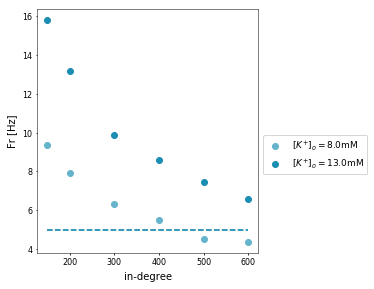

<Figure size 410.4x360 with 0 Axes>

In [123]:
# ax=sns.lmplot(x ='in-degree', y ='v_E', hue ='K_o',
#            fit_reg = False, data = df_stats) 

f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax=plt.subplot2grid((10,10), (0, 0), colspan=7,rowspan=9)


cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)


ge_amp_i=0.035
gi_amp_i=0.27
tau_e=5/1000.0
tau_i=10/1000.0
for koii in np.unique(df_stats_5Hz['K_o']):
    colorii=next(colors)
    ax.plot(df_stats_5Hz['in-degree'][df_stats_5Hz['K_o']==koii],df_stats_5Hz['v_E'][df_stats_5Hz['K_o']==koii],'o',color=colorii,label='$[K^{+}]_o='+str(koii)+'$ mM')
    idxkoii=[ii for ii,koi in enumerate(koivv2) if koii==koi]
#     I_apii_ko=iapi_v[idxkoii[0]]
    I_apii_ko=iapi
    ve_theori=-I_apii_ko/(200*(tau_e*ge_amp_i-tau_i*gi_amp_i))
    ax.plot(np.linspace(150,600,5),np.ones(5)*ve_theori,'--',color=colorii)
    if koii==13:
        print('Ko='+str(koii))
        print(str(ve_theori))
        print(I_apii_ko)

ax.set_ylabel('Fr [Hz]',labelpad=5)
ax.set_xlabel('in-degree',labelpad=5)
ax.legend(loc='best', bbox_to_anchor=(1, 0.5))
    
dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
name_file='PopulationActivity_vs_K_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
iapp='I_app'
ko='K_o'
stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=name_file+stringi+'N_'+str(num_neurons)+'_multKs_scaled_MFT_5Hz'
fig_file_title='fig_'+name
md_dir={
        'Title':'PopulationActivity PowerSpectrum',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]))),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

saving_pdf_figure(f11,'./Figs/'+fig_file_title,md_dir)

f11.show()

In [118]:
K_v

[150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 500.0, 600.0]

8.0
200.0
4.0000020000009995
13.0
200.0
2.0000010000004997
8.0
400.0
1.0000005000002499
13.0
400.0
2.0000010000004997
8.0
500.0
5.00000250000125
13.0
500.0
3.0000015000007494


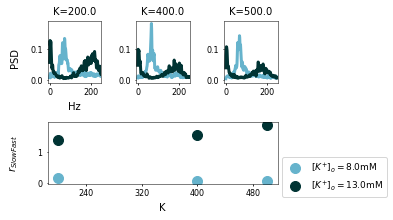

<Figure size 410.4x360 with 0 Axes>

In [124]:
lxaxs=250

v_num_neurons_ii=K_v
ii_K_specf=[1,5,6]

f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.6))
ax=[]

i_N_st_tot=0
for i_N in ii_K_specf:
    if len(a_f_lfp_v_5Hz[i_N][0])>0:
        i_N_st_tot+=1



i_N_st=0
for i_N in ii_K_specf:
    if len(a_f_lfp_v_5Hz[i_N][0])>0:
        if i_N_st==0:
            ax.append(plt.subplot2grid((5,3*i_N_st_tot+2), (0, i_N_st*3), colspan=2,rowspan=2))
        else:
            ax.append(plt.subplot2grid((5,3*i_N_st_tot+2), (0, i_N_st*3),sharey=ax[0], colspan=2,rowspan=2))
    
        i_N_st+=1
        
ax.append(plt.subplot2grid((5,3*i_N_st_tot+2), (3, 0), colspan=3*i_N_st_tot-1,rowspan=2))



a_v_ratio=[]
i_N_st=0
v_num_neurons_ii_st=[]
for i_N in ii_K_specf:
    Spectrogram_Fr_v=a_f_lfp_v_5Hz[i_N]
    Spectrogram_v=a_p_lfp_v_5Hz[i_N]
    size_legend_font=20
    cmap=plt.get_cmap('ocean')
    colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
    colorii=next(colors)
    colorii=next(colors)
    v_ratio=[]
    if len(a_f_lfp_v_5Hz[i_N][0])>0:
        for koii in range(len(koivv2)):
            colorii=next(colors)
            if koii in [0,6]:
                ax[i_N_st].plot(Spectrogram_Fr_v[koii], Spectrogram_v[koii],label='$[K^{+}]_o='+str(koivv2[koii])+'$ mM',color=colorii,linewidth=3)
                ax[i_N_st].set_xlim([-3,lxaxs])
                slw_peak=max(Spectrogram_v[koii][Spectrogram_Fr_v[koii]<6])
                print(str(koivv2[koii]))
                print(v_num_neurons_ii[i_N])
                print(Spectrogram_Fr_v[koii][argmax(Spectrogram_v[koii][Spectrogram_Fr_v[koii]<6])])
                fst_peak=max(Spectrogram_v[koii][(Spectrogram_Fr_v[koii]>50)*(Spectrogram_Fr_v[koii]<lxaxs)])
                v_ratio.append(slw_peak/fst_peak)

        a_v_ratio.append(v_ratio)
        v_num_neurons_ii_st.append(v_num_neurons_ii[i_N])
        ax[i_N_st].set_xlim([-10,lxaxs])
        ax[i_N_st].set_title('K='+str(v_num_neurons_ii[i_N]))
        i_N_st+=1
    
# ax[0].set_ylabel('PSD',fontsize=size_axis_font,labelpad=10)
# ax[0].set_xlabel('Hz',fontsize=size_axis_font,labelpad=10)
ax[0].set_ylabel('PSD',labelpad=5)
ax[0].set_xlabel('Hz',labelpad=5)


# ax[len(v_num_neurons)-1].set_xlabel('[Hz]',fontsize=size_axis_font,labelpad=10)


cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)
cc=0
for koii in range(len(koivv2)):
    colorii=next(colors)
    if koii in [0,6]:
        ax[-1].plot(v_num_neurons_ii_st, np.array(a_v_ratio).T[cc],'o',markersize=10, label='$[K^{+}]_o='+str(koivv2[koii])+'$ mM',color=colorii)
        cc+=1

# ax[len(v_num_neurons_ii)].set_xlabel('N',fontsize=size_axis_font,labelpad=10)
# ax[len(v_num_neurons_ii)].set_ylabel(r'$r_{SlowFast}$',fontsize=size_axis_font,labelpad=10)
ax[-1].set_xlabel('K',labelpad=5)
ax[-1].set_ylabel(r'$r_{SlowFast}$',labelpad=5)


# ax[len(v_num_neurons_ii)-1].legend(title='Extracellular potassium',loc='best', bbox_to_anchor=(1, 1),prop={'size': size_legend_font})
# ax[len(v_num_neurons_ii)-1].legend(loc='best', bbox_to_anchor=(1, 0.5),prop={'size': size_legend_font})
ax[-1].legend(loc='best', bbox_to_anchor=(1, 0.5))



# locatory1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
ax[-1].xaxis.set_major_locator(locatorx1)

############################################
### Aligning y labels
############################################
labely = -0.12  # axes coords
boxP =ax[i_N_st].get_position()
box0p =ax[0].get_position()
ax[i_N_st].yaxis.set_label_coords(labely, 0.5)
ax[0].yaxis.set_label_coords(boxP.width/box0p.width*labely, 0.4)



dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
name_file='PopulationActivity_PowerSpectrum__num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
iapp='I_app'
ko='K_o'
stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=name_file+stringi+'N_'+str(num_neurons)+'_K_scaled_MFT_5Hz'
fig_file_title='fig_'+name
md_dir={
        'Title':'PopulationActivity PowerSpectrum',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]))),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

saving_pdf_figure(f11,'./Figs/'+fig_file_title,md_dir)

f11.show()

In [111]:
name

'PopulationActivity_PowerSpectrum__num_runs_1_lengthSim_20000_K_o_13_I_app_25ge_2_gi_15N_4000_multKs'

In [57]:
# plt.plot(f_lfp_v_5Hz[0],p_lfp_v_5hz[0])
# plt.xlim(0,500)

In [56]:
# name='d_Network_N_4000_num_runs_1_lengthSim_20000K_o_8_I_app_13ge_2_gi_15pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_inDegreeK_600_scaled_MFT_2pt61Hz'
# dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'
# print(os.path.isfile(dir_sims+name+'.pkl'))
# if os.path.isfile(dir_sims+name+'.pkl'):
#     try:
#         print(name + ' Exists, or is being calculated.. :)')
#         with open(dir_sims+name+'.pkl', "rb") as f:
#             dir_i = pickle.load(f)

#             for ii in range(len(dir_i)):
#                 print(dir_i[ii]['d_Protocol'])

#                 ## 6. Power spectrum population rates
#                 tt=dir_i[ii]['Population_Rate']['t']
#                 x=dir_i[ii]['Population_Rate']['Freq_Pop']
#                 fs=len(x)/((tt[-1]-tt[0])/1000)
#                 sliding_window=int(fs/1.0)#To get a 2.0Hz resolution
#                 overlap = 0.0
#                 n_overlap = int(sliding_window * overlap)
#                 f_lfp, p_lfp = signal.welch(x-np.mean(x), fs,'flattop',nperseg=sliding_window, noverlap=n_overlap,scaling='spectrum')
#     except:
#         pass

In [55]:
# plt.plot(f_lfp,p_lfp)
# plt.xlim(0,500)